In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import random
from nltk.tokenize.regexp import RegexpTokenizer
from sklearn.feature_extraction.text import CountVectorizer
from  nltk.stem.snowball import FrenchStemmer, EnglishStemmer
from wordcloud import WordCloud, STOPWORDS
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import chi2
import numpy as np
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from bs4 import BeautifulSoup
from nltk.tokenize import WordPunctTokenizer
import unidecode
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from googletrans import Translator
import re
from bs4 import BeautifulSoup
from nltk.tokenize import WordPunctTokenizer
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import classification_report
from sklearn.svm import LinearSVC
import seaborn as sns


from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"


/Users/Michi/anaconda/lib/python2.7/site-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [49]:
# Edit this with the path to your data
tweet_file = '_Tweets_labels_manuels.xlsx'

tw_data = pd.read_excel(tweet_file)

tw_data.head(3)

tw_data.loc[tw_data.Label=='SH', 'Label']='S'



,ID,Texte,Label
0,998206424189751296,On m’avait sorti (pour de vrai) « on est tous ...,N
1,997896508384169984,VIVE L AMOUR ❤VIVE LA PAIX\n❤❤❤❤❤❤❤❤❤❤❤❤👏👍\n...,N
2,31,J'me rend compte à quel point ya trop d'noir d...,S


# Feature preparation. Add features, clean tweets, sentiment analysis, vectorization

Lexical features  by Patrick

In [34]:
def add_lexical_features(df):
    urls = re.compile(r"http")
    ats = re.compile(r"@[a-zA-Z.]*")
    hashtags = re.compile(r"#[a-zA-Z]*")
    letters = re.compile(r"[a-zA-Z]")
    caps = re.compile(r"[A-Z]")
    fancy = [';','"','(','«']

    nbr_characters = [len(s) for s in df.Texte]
    df['nbr_characters'] = pd.DataFrame(nbr_characters, index=df.index)

    nbr_words = [len(s.split()) for s in df.Texte] # to update after cleaning
    df['nbr_words'] = pd.Series(nbr_words, index=df.index)

    nbr_ats = [len(ats.findall(text)) for text in df.Texte]
    df['nbr_ats'] = pd.Series(nbr_ats, index=df.index)

    nbr_hashtags = [len(hashtags.findall(text)) for text in df.Texte]
    df['nbr_hashtags'] = pd.Series(nbr_hashtags, index=df.index)

    nbr_urls = [len(urls.findall(text)) for text in df.Texte]
    df['nbr_urls'] = pd.Series(nbr_urls, index=df.index)

    nbr_letters = [len(letters.findall(text)) for text in df.Texte]
    df['nbr_letters'] = pd.Series(nbr_letters, index=df.index)

    nbr_caps = [len(caps.findall(text)) for text in df.Texte]
    df['nbr_caps'] = pd.Series(nbr_caps, index=df.index)

    nbr_fancy = [sum(1 for c in text if c in fancy) for text in df.Texte]
    df['nbr_fancy'] = pd.Series(nbr_fancy, index=df.index)

    return df
 


Clean Text by Patrick

In [51]:

my_dict={"aujourd'hui":"aujourdhui", "s'il":"si il", "s'":"se ","n'":"ne ", 'jte':"je te", 'pck':'parce que', 'jms':'jamais',
        'fdp': 'fis de pute', 'ptn': 'putaine', 'pcq':'parce que', 'tt': 'toute', 'vrmt': 'vraiment'}



def tweet_cleaner(text, my_dict):
    
    # fixes encoding problem (MICHELE)
    if type(text)!=unicode:
        try: 
            text= unicode(text,'utf-8')
        except UnicodeDecodeError: 
            text= unicode(text,'latin-1')
    
    tok = WordPunctTokenizer()

    pat1 = r'@[A-Za-z0-9_]+'
    pat2 = r'https?://[^ ]+'
    combined_pat = r'|'.join((pat1, pat2))
    www_pat = r'www.[^ ]+'
 
    text = unidecode.unidecode(text)
    soup = BeautifulSoup(text, 'lxml')
    souped = soup.get_text()
    try:
        bom_removed = souped.decode("utf-8-sig").replace(u"\ufffd", "?")
    except:
        bom_removed = souped
    stripped = re.sub(combined_pat, '', bom_removed)
    stripped = re.sub(www_pat, '', stripped)
    lower_case = stripped.lower()
    letters_only = re.sub("[^a-zA-Z]", " ", lower_case)
    
    # replace common abbreviations with full expression (MICHELE)
    for word in my_dict:
        letters_only = re.sub(word, my_dict[word], letters_only)

    # During the letters_only process two lines above, it has created unnecessay white spaces,
    # I will tokenize and join together to remove unneccessary white spaces
    words = [x for x  in tok.tokenize(letters_only) if len(x) > 1]
    return (" ".join(words)).strip()


def tokenize(text):
    tweet = " ".join(re.split("[^a-zA-Z]*", text.lower())).strip()
    stemmer = FrenchStemmer()
    tokens = [stemmer.stem(t) for t in tweet.split()]
    return tokens



Tf-idf

In [53]:

def generate_stopwords():
    stopwords_en = nltk.corpus.stopwords.words("english")
    stopwords_fr = nltk.corpus.stopwords.words("french")
    stop_words = stopwords_en+stopwords_fr
    other_exclusions = ["#ff", "ff", "rt"]
    stop_words.extend(other_exclusions)
    return stop_words


def get_tfidf_frequencies(data):

    # Note: Equivalent to CountVectorizer followed by TfidfTransformer
    tfidf = TfidfVectorizer(sublinear_tf=True, 
                            tokenizer=tokenize,
                            preprocessor=lambda x: tweet_cleaner(x, my_dict),
                            ngram_range=(1, 3),
                            use_idf=True,
                            smooth_idf=False,
                            norm=None,
                            decode_error='replace',
                            max_features=10000,
                            min_df=5,
                            max_df=0.75,
                            stop_words=generate_stopwords())

    features = tfidf.fit_transform(data).toarray()
    sum_words = features.sum(axis=0)
    words_freq ={word: sum_words[idx] for word,idx in tfidf.vocabulary_.items()}
    vocab = {v:i for i, v in enumerate(tfidf.get_feature_names())}

    return features, words_freq, vocab

In [85]:

# add lexical features and get numpy array
tw_data = add_lexical_features(tw_data)

lex_cols = ['nbr_characters','nbr_words', 'nbr_ats', 'nbr_hashtags', 'nbr_urls',
            'nbr_letters','nbr_caps', 'nbr_fancy' ]
lex_features = tw_data.as_matrix(columns=lex_cols)
lex_features.shape


# features is the Tf-idf-weighted document-term matrix as a numpy array
features, words_freq, vocab = get_tfidf_frequencies(tw_data.Texte)

features.shape

/Users/Michi/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:30: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal


(1000, 8)

(1000, 1039)

In [86]:
# M is the feature matrix, ready for ML. It is a numpy array with dim. n_samples x n_features
# For now, n_features> n_samples --->  !!! Reduce features !!!

M = np.concatenate([features,lex_features],axis=1)
M.shape

(1000, 1047)

# ML

Suggestions to go on:
- try methods for feature reduction (PCA, ....)
- try different algorithms, tune parameters (grid search) & compare results
- try to output probabilities & signal tweet only if P > some_value

In [87]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.pipeline import Pipeline

In [88]:
#X = pd.DataFrame(M)
tw_data['Label_id']=tw_data['Label'].factorize()[0]
label_id_df_fr = tw_data[['Label', 'Label_id']].drop_duplicates().sort_values('Label_id')
label_to_id_fr = dict(label_id_df_fr.values)

y = tw_data['Label_id'].as_matrix()

label_to_id_fr

{u'H': 2, u'N': 0, u'S': 1}

In [89]:
X_train, X_test, y_train, y_test = train_test_split(M, y, random_state=42, test_size=0.1)

In [90]:
pipe = Pipeline(
        [('select', SelectFromModel(LogisticRegression(class_weight='balanced',
                                                  penalty="l1", C=0.01))),
        ('model', LogisticRegression(class_weight='balanced',penalty='l2'))])

In [91]:
param_grid = [{}] # Optionally add parameters here

grid_search = GridSearchCV(pipe, 
                           param_grid,
                           cv=StratifiedKFold(n_splits=5, 
                                              random_state=42).split(X_train, y_train), 
                           verbose=2)

In [92]:
model = grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV]  ................................................................
[CV] ................................................. , total=   0.2s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s


[CV] ................................................. , total=   0.2s
[CV]  ................................................................
[CV] ................................................. , total=   0.2s
[CV]  ................................................................
[CV] ................................................. , total=   0.2s
[CV]  ................................................................
[CV] ................................................. , total=   0.2s


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.0s finished


In [93]:
y_preds = model.predict(X_test)

In [94]:
print(classification_report( y_test, y_preds ))

             precision    recall  f1-score   support

          0       0.87      0.88      0.87        82
          1       0.43      0.25      0.32        12
          2       0.20      0.33      0.25         6

avg / total       0.77      0.77      0.77       100



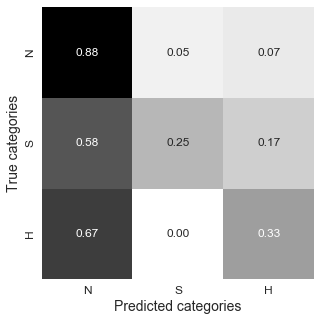

In [95]:
from sklearn.metrics import confusion_matrix

confusion_matrix = confusion_matrix(y_test,y_preds)
matrix_proportions = np.zeros((3,3))
for i in range(0,3):
    matrix_proportions[i,:] = confusion_matrix[i,:]/float(confusion_matrix[i,:].sum())
names=['N','S','H']
confusion_df = pd.DataFrame(matrix_proportions, 
                            index=names,columns=names)
plt.figure(figsize=(5,5))
sns.heatmap(confusion_df,annot=True,
            annot_kws={"size": 12},cmap='gist_gray_r',
            cbar=False, square=True,fmt='.2f');
plt.ylabel(r'True categories',fontsize=14);
plt.xlabel(r'Predicted categories',fontsize=14);
plt.tick_params(labelsize=12);


# DataViz. Most frequent wrds/n-grams, correlation matrix, wordcloud

Wordcloud

In [ ]:
tw_data_bad = tw_data.loc[(tw_data['Label']=='H') | (tw_data['Label']=='S')]
tw_data_good = tw_data.loc[(tw_data['Label']=='N')]


features_bad_tfidf, words_freq_bad_tfidf = get_tfidf_frequencies(tw_data_bad.Text_cleaned)
features_good_tfidf, words_freq_good_tfidf = get_tfidf_frequencies(tw_data_good.Text_cleaned)

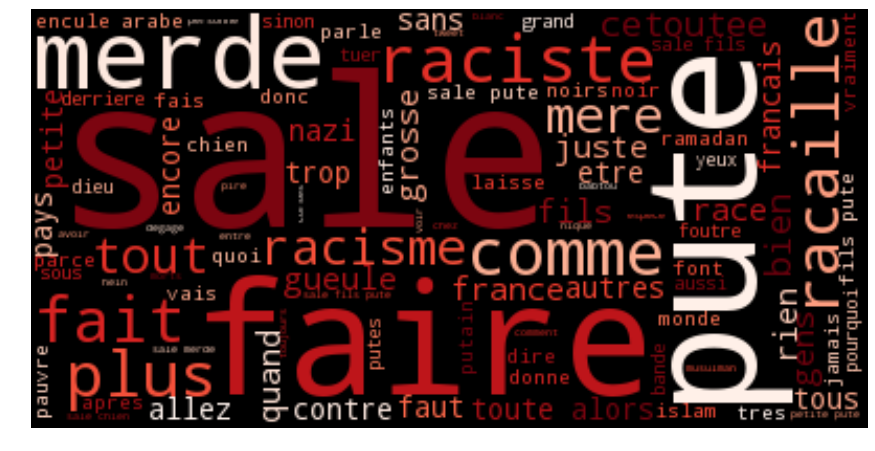

In [41]:
wc_bad_tfidf = WordCloud( background_color='black', max_words=100, 
                   stopwords=generate_stopwords(), max_font_size=100,
                  colormap="Reds")
   
plt.figure(figsize= (15,10));
wc_bad_tfidf.generate_from_frequencies(words_freq_bad_tfidf);
plt.axis("off");
plt.margins(x=0, y=0);
plt.imshow(wc_bad_tfidf, interpolation="bilinear");



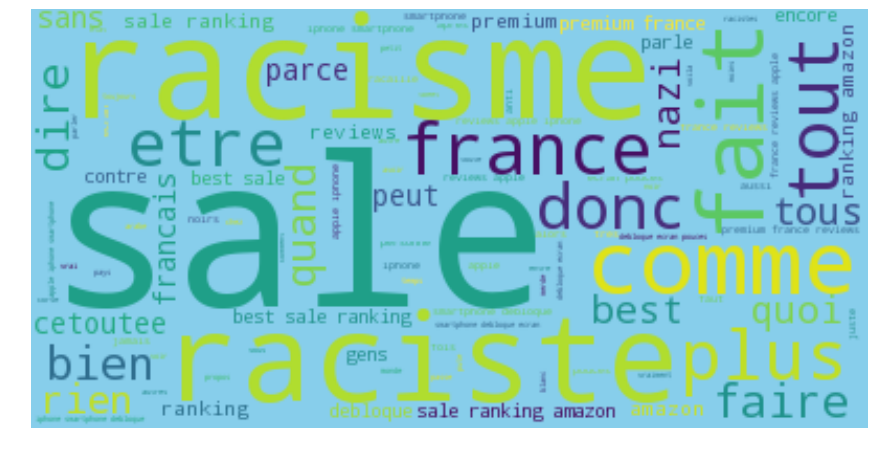

In [42]:
wc_good_tfidf = WordCloud( background_color='skyblue', max_words=100, 
                   stopwords=generate_stopwords(), max_font_size=100)
   
plt.figure(figsize= (15,10));
wc_good_tfidf.generate_from_frequencies(words_freq_good_tfidf);
plt.axis("off");
plt.margins(x=0, y=0);
plt.imshow(wc_good_tfidf, interpolation="bilinear");



Most correlated n-grams (n=1,2)

In [45]:
def print_n_grams(features_df, labels, label_to_id_dict, N=3, n_grams_max=2):

    tfidf = TfidfVectorizer(sublinear_tf=True, 
                            tokenizer=tokenize,
                            preprocessor= lambda x: tweet_cleaner(x, my_dict),
                            min_df=5,
                            max_df=0.75,
                            norm='l2', 
                            encoding='utf-8', 
                            ngram_range=(1,n_grams_max), 
                            stop_words=generate_stopwords())

    features = tfidf.fit_transform(features_df).toarray()

    n_grams = {}
    for Product, category_id in sorted(label_to_id_dict.items()):
        features_chi2 = chi2(features, labels == category_id)
        indices = np.argsort(features_chi2[0])
        feature_names = np.array(tfidf.get_feature_names())[indices]
        
        
        print("# '{}':".format(Product))
        for n in range(1,n_grams_max+1):
            ind_name=Product+'_'+str(n)
            n_grams[ind_name]= [v for v in feature_names if len(v.split(' ')) == n]
            print("  . Most correlated %s-grams:\n. %s" %(n, '\n. '.join(n_grams[ind_name][-N:])))
        
    return n_grams




In [51]:
tw_data['Label_id']=tw_data['Label'].factorize()[0]
label_id_df_fr = tw_data[['Label', 'Label_id']].drop_duplicates().sort_values('Label_id')
label_to_id_fr = dict(label_id_df_fr.values)

n_grams_fr = print_n_grams(tw_data['Text_cleaned'], tw_data['Label_id'], 
                           label_to_id_fr, N=3, n_grams_max=2)

# 'H':
  . Most correlated 1-grams:
. putes
. encule
. pute
  . Most correlated 2-grams:
. sale chien
. sale fils
. fils pute
# 'N':
  . Most correlated 1-grams:
. fiches
. merde
. pute
  . Most correlated 2-grams:
. petite pute
. fiches sinon
. fils pute
# 'S':
  . Most correlated 1-grams:
. autorite
. juif
. fiches
  . Most correlated 2-grams:
. ordonne tuer
. periode dehors
. fiches sinon


Sentiment (VERY SLOW !!!! - due to translation API)

In [56]:
def my_trans(x):
    translator = Translator()
    try: tr = translator.translate(x, src='fr', dest='en').text
    except ValueError: tr = ''
    return tr


def add_sentiment(df, col):
    
    col_eng=col+'_en'
    print('Translating to english...')
    tw_data[col_eng] = tw_data[col].apply(lambda tweet: my_trans(tweet_cleaner(tweet, my_dict)))
    
    dict_en={"isn't":"is not", "aren't":"are not", "wasn't":"was not", "weren't":"were not",
                "haven't":"have not","hasn't":"has not","hadn't":"had not","won't":"will not",
                "wouldn't":"would not", "don't":"do not", "doesn't":"does not","didn't":"did not",
                "can't":"can not","couldn't":"could not","shouldn't":"should not","mightn't":"might not",
                "mustn't":"must not"}

    print('Translation finished. Creating vectorizer......')
    vectorizer = TfidfVectorizer(sublinear_tf=True, 
                            tokenizer=tokenize,
                            preprocessor= lambda x: tweet_cleaner(x, dict_en),
                            min_df=10,
                            max_df=0.5,
                            norm='l2', 
                            encoding='utf-8', 
                            stop_words=generate_stopwords(),
                            use_idf=True)

    
    X = vectorizer.fit_transform(df[col_eng])
    sid = SentimentIntensityAnalyzer()
    df['sentiment_compound_polarity']=df[col_eng].apply(lambda x:sid.polarity_scores(x)['compound'])
    df['sentiment_neutral']=df[col_eng].apply(lambda x:sid.polarity_scores(x)['neu'])
    df['sentiment_negative']=df[col_eng].apply(lambda x:sid.polarity_scores(x)['neg'])
    df['sentiment_pos']=df[col_eng].apply(lambda x:sid.polarity_scores(x)['pos'])
    df['sentiment_type']=''
    df.loc[df.sentiment_compound_polarity>0,'sentiment_type']='POSITIVE'
    df.loc[df.sentiment_compound_polarity==0,'sentiment_type']='NEUTRAL'
    df.loc[df.sentiment_compound_polarity<0,'sentiment_type']='NEGATIVE'
    
    return df

Plot correlation matrix between sentiment and label 

In [ ]:
# Get sentiment (VERY SLOW) .
# Comment out the next three lines not to use sentiment.
tw_data = add_sentiment(tw_data, 'Texte') 

sent_cols = ['sentiment_compound_polarity','sentiment_neutral',
             'sentiment_negative','sentiment_pos' ]
sent_features = tw_data.as_matrix(columns=sent_cols)



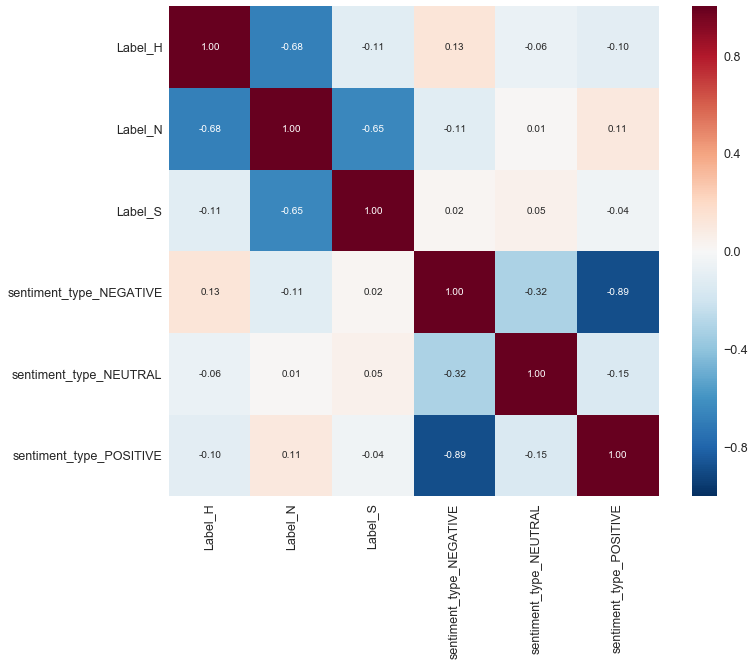

,Label_H,Label_N,Label_S,sentiment_type_NEGATIVE,sentiment_type_NEUTRAL,sentiment_type_POSITIVE
Label_H,1.000000,-0.679848,-0.110427,0.128901,-0.063601,-0.103774
Label_N,-0.679848,1.000000,-0.653794,-0.109804,0.013082,0.108225
Label_S,-0.110427,-0.653794,1.000000,0.015813,0.047894,-0.039599
sentiment_type_NEGATIVE,0.128901,-0.109804,0.015813,1.000000,-0.318715,-0.889339
sentiment_type_NEUTRAL,-0.063601,0.013082,0.047894,-0.318715,1.000000,-0.149958
sentiment_type_POSITIVE,-0.103774,0.108225,-0.039599,-0.889339,-0.149958,1.000000


In [84]:


def create_dummies(df,column_name):
    dummies = pd.get_dummies(df[column_name],prefix=column_name)
    df = pd.concat([df,dummies],axis=1)
    return df

def sentiment_correlation(df, cols):

    for col in cols:
        df = create_dummies(df, col)
    
    df_corr  = df.iloc[:,df.shape[1]-7:df.shape[1]]
    df_corr = df_corr.drop('Label_id', axis=1)
    corrmat = df_corr.corr()
    f, ax = plt.subplots(figsize=(12, 9)) # this only to make a larger figure
    #sns.heatmap(corrmat, vmax=.8, square=True);
    sns.set(font_scale=1.25)
    colsInd = corrmat.index
    hm = sns.heatmap(corrmat, cbar=True, annot=True, square=True, fmt='.2f',
                     annot_kws={'size': 10}, 
                 yticklabels=colsInd.values, xticklabels=colsInd.values)
    plt.show()
        
    return corrmat


sentiment_correlation(tw_data, ['Label', 'sentiment_type'])